In [1]:
version = '5.5.0'

# Test data

In [2]:
# from https://github.com/guillaume-chevalier/seq2seq-signal-prediction
import local_datasets  

exercice_number = 1
print('exercice {}\n=================='.format(exercice_number))

data_inputs, expected_outputs = local_datasets.generate_data(
    # See: https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/datasets.py
    exercice_number=exercice_number,
    # n_samples=125000,
    # window_size_past=40,
    # window_size_future=40
    n_samples=None,
    window_size_past=None,
    window_size_future=None
)

print('data_inputs shape: {} => (n_samples, window_size_past, input_dim)'.format(data_inputs.shape))
print('expected_outputs shape: {} => (n_samples, window_size_future, output_dim)'.format(expected_outputs.shape))

sequence_length = data_inputs.shape[1]
input_dim = data_inputs.shape[2]
output_dim = expected_outputs.shape[2]


exercice 1
data_inputs shape: (1000, 10, 2) => (n_samples, window_size_past, input_dim)
expected_outputs shape: (1000, 10, 2) => (n_samples, window_size_future, output_dim)


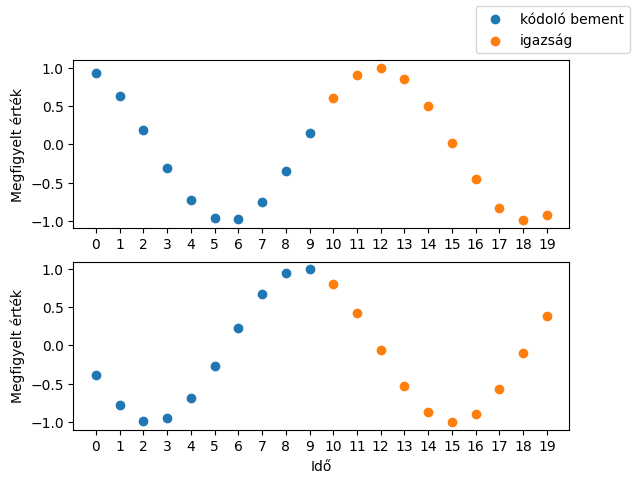

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

def plot_serial(plot_index, encoder_input, decoder_output, prediction=None):
    feature_number = encoder_input.shape[2]
    fig, ax = plt.subplots(feature_number,1)
    for i in range(feature_number):
        encoder_train = encoder_input[plot_index,:,i]
        true = decoder_output[plot_index,:,i]

        ax[i].set_ylabel('Megfigyelt érték')
        if i == 0:
            ax[i].scatter(
                range(encoder_train.shape[0]), encoder_train, label="kódoló bement"
            )
            ax[i].scatter(
                range(encoder_train.shape[0], true.shape[0]+encoder_train.shape[0]), 
                true, label="igazság"
            )
        else:
            ax[i].scatter(
                range(encoder_train.shape[0]), encoder_train,
            )
            ax[i].scatter(
                range(encoder_train.shape[0], true.shape[0]+encoder_train.shape[0]),
                true
            )
        ax[i].xaxis.set_major_locator(MultipleLocator(1))
        if prediction is not None:
            i_prediction = prediction[plot_index,:,i]
            if i == 0:
                ax[i].plot(
                    range(
                        encoder_train.shape[0], 
                        i_prediction.shape[0]+encoder_train.shape[0]
                    ), 
                    i_prediction, label="előrejelzés"
                )
            else:
                ax[i].plot(
                    range(
                        encoder_train.shape[0], 
                        i_prediction.shape[0]+encoder_train.shape[0]
                    ), 
                    i_prediction,
                )
    ax[-1].set_xlabel('Idő')
    fig.legend()
    plt.show()

plot_serial(0, data_inputs, expected_outputs)

In [4]:
# cut to train, validate and test
train_end_indx = round(0.5 * data_inputs.shape[0])
test_end_indx = train_end_indx + round(0.25 * data_inputs.shape[0])

X_train = data_inputs[: train_end_indx, :, :]
X_val = data_inputs[train_end_indx : test_end_indx, :, :]
X_test = data_inputs[test_end_indx: , :, :]
y_train = expected_outputs[: train_end_indx, :, :]
y_val = expected_outputs[train_end_indx : test_end_indx, :, :]
y_test = expected_outputs[test_end_indx: , :, :]

# seq2seq modell

In [5]:
import tensorflow as tf
import numpy as np

In [6]:
# model parameters
lr = 0.001
num_epochs = 1000
batch_size = 100
hidden_size = 35
num_gru_layers = 1
grad_clip = 1.0
scheduled_sampling_decay = 10
dropout = 0.2

In [7]:
no_vars_input = X_train.shape[2]
no_vars_output = y_train.shape[2]
input_sequence_length = X_train.shape[1]
prediction_length = y_train.shape[1]

In [8]:
def seq2seq_model(
    hidden_size: int, 
    dropout: float, 
    lr: float, 
    delta: float = 1.35, 
    grad_clip: float = 1.0
):
    """
    seq2seq model without attention

    """
    input_sequence = tf.keras.layers.Input(shape=(input_sequence_length, no_vars_input))

    # discard encoder output
    # GRU the last_encoder_outputs == state_h
    last_encoder_outputs, state_h = tf.keras.layers.GRU(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_sequences=False, 
        return_state=True
    )(input_sequence)
    
    decoder = tf.keras.layers.RepeatVector(prediction_length)(state_h)
    decoder = tf.keras.layers.GRU(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_state=False, 
        return_sequences=True
    )(decoder, initial_state=state_h)

    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(no_vars_output))(decoder)

    seq2seq = tf.keras.Model(inputs=input_sequence, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=grad_clip)
    seq2seq.compile(loss=tf.keras.losses.Huber(delta=delta), optimizer=opt, metrics=['mae'])

    return seq2seq


In [9]:
def seq2seq_stacked_model(hidden_size: int, dropout: float, lr: float, delta: float = 1.35, grad_clip: float = 1.0, logging=False):
    input_train = tf.keras.layers.Input(shape=(input_sequence_length, no_vars_input))

    rnn_cells_encoder = [tf.keras.layers.GRUCell(int(hidden_size), dropout=dropout, activation='elu') for _ in range(3)]
    stacked_gru_encoder = tf.keras.layers.StackedRNNCells(rnn_cells_encoder)
    last_encoder_outputs, *state_h = tf.keras.layers.RNN(
        stacked_gru_encoder,  
        return_sequences=False, 
        return_state=True
    )(input_train)

    decoder = tf.keras.layers.RepeatVector(prediction_length)(last_encoder_outputs)
    rnn_cells_decoder = [tf.keras.layers.GRUCell(int(hidden_size), dropout=dropout, activation='elu') for _ in range(3)]
    stacked_gru_decoder = tf.keras.layers.StackedRNNCells(rnn_cells_decoder)
    decoder = tf.keras.layers.RNN(
        stacked_gru_decoder, 
        return_state=False, 
        return_sequences=True
    )(decoder, initial_state=state_h)

    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(no_vars_output))(decoder)

    seq2seq = tf.keras.Model(inputs=input_train, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=grad_clip)
    seq2seq.compile(loss=tf.keras.losses.Huber(delta=delta), optimizer=opt, metrics=['mae'])
    
    if logging:
        seq2seq.summary()

    return seq2seq

In [10]:
def seq2seq_attention_model_gru(
    hidden_size: int, 
    dropout: float, 
    lr: float, 
    attention_type: str, 
    delta: float = 1.35, 
    grad_clip: float = 1.0, 
    logging: bool=False
):
    """

    """
    input_sequence = tf.keras.layers.Input(shape=(input_sequence_length, no_vars_input))

    encoder_stacked_h, encoder_h = tf.keras.layers.GRU(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_sequences=True, 
        return_state=True
    )(input_sequence)

    decoder = tf.keras.layers.RepeatVector(prediction_length)(encoder_h)
    decoder_stacked_h = tf.keras.layers.GRU(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_sequences=True,
        return_state=False, 
    )(decoder, initial_state=encoder_h)

    # Luong Attention
    if attention_type == 'Loung':
        attention = tf.keras.layers.dot([decoder_stacked_h, encoder_stacked_h], axes=[2, 2])
        attention = tf.keras.layers.Activation('softmax')(attention)
        attention_output = tf.keras.layers.dot([attention, encoder_stacked_h], axes=[2,1])
    elif attention_type == 'Bahdanau':
        attention = tf.keras.layers.AdditiveAttention()
        attention_output = attention([decoder_stacked_h, encoder_stacked_h])
    else:
        raise ValueError("Nem megfelelő Figyelem tipus.")
        
    # Concatenating attention output and decoder LSTM output 
    decoder_combined_context = tf.keras.layers.concatenate([decoder_stacked_h, attention_output])
    
    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(no_vars_output))(decoder_combined_context)

    seq2seq = tf.keras.Model(inputs=input_sequence, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=grad_clip)
    seq2seq.compile(loss=tf.keras.losses.Huber(delta=delta), optimizer=opt, metrics=['mae'])
    
    if logging:
        seq2seq.summary()

    return seq2seq


In [11]:
def seq2seq_attention_model_lstm(
    hidden_size: int, 
    dropout: float, 
    lr: float, 
    attention_type: str, 
    delta: float = 1.35, 
    grad_clip: float = 1.0, 
    logging: bool=False
):
    """

    """
    input_sequence = tf.keras.layers.Input(shape=(input_sequence_length, no_vars_input))

    encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_sequences=True, 
        return_state=True
    )(input_sequence)

    decoder = tf.keras.layers.RepeatVector(prediction_length)(encoder_last_h)
    decoder_stack_h = tf.keras.layers.LSTM(
        int(hidden_size), 
        activation='elu', 
        dropout=dropout, 
        return_sequences=True,
        return_state=False, 
    )(decoder, initial_state=[encoder_last_h, encoder_last_c])

    # Luong Attention
    if attention_type == 'Loung':
        attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
        attention = tf.keras.layers.Activation('softmax')(attention)
        context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
        decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
    elif attention_type == 'Bahdanau':
        attention = tf.keras.layers.AdditiveAttention()
        attention_output = attention([encoder_stack_h, decoder_stack_h])

        # Concatenating attention output and decoder LSTM output 
        decoder_combined_context = tf.keras.layers.concatenate([decoder_stack_h, attention_output])
    else:
        raise ValueError("Nem megfelelő Figyelem tipus.")

    out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(no_vars_output))(decoder_combined_context)

    seq2seq = tf.keras.Model(inputs=input_sequence, outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=grad_clip)
    seq2seq.compile(loss=tf.keras.losses.Huber(delta=delta), optimizer=opt, metrics=['mae'])
    
    if logging:
        seq2seq.summary()

    return seq2seq


In [12]:
import hyperopt

class HyperparamOpt:
    def __init__(self, space: dict):
        """
        Args:
          * space -- the space for the hyperparameter optimization
          * score -- how we score the model, needs to sync with the 'loss'
                     if high score is the better model, we need to set the 'loss' to False
          * loss -- the score is a loss function or not, it is True the smaller value is better,
                    ex: f1 is not one, as 1 is the best and 0 is the worst value
        """
        self.space = space
        self.models = []

    def hyperparameter_tuning(self, space: dict) -> dict:
        if self.model_type == 'bahdanau_lstm':
            seq2seq = seq2seq_attention_model_lstm(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"],
                attention_type='Bahdanau'
            )
        if self.model_type == 'bahdanau_gru':
            seq2seq = seq2seq_attention_model_gru(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"],
                attention_type='Bahdanau'
            )
        elif self.model_type == 'stacked':
            seq2seq = seq2seq_stacked_model(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"]
            )
        elif self.model_type == 'loung_lstm':
            seq2seq = seq2seq_attention_model_lstm(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"],
                attention_type='Loung'
            )
        elif self.model_type == 'loung_gru':
            seq2seq = seq2seq_attention_model_gru(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"],
                attention_type='Loung'
            )
        else:
            seq2seq = seq2seq_model(
                hidden_size=space["hidden_size"], 
                dropout=space["dropout"], 
                lr=space["lr"]
            )
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50, restore_best_weights=True)
        _ = seq2seq.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=num_epochs, 
            batch_size=int(space["batch_size"]), 
            shuffle=False,
            verbose=0,
            callbacks=[early_stop]
        )

        y_hat = seq2seq.predict(self.X_test)
        loss = np.sum(np.abs(self.y_test - y_hat).flatten())

        self.models.append({
            'space': space,
            'loss': loss,
        })
        
        return {'loss': loss, 'status': hyperopt.STATUS_OK}
        
    def train(self, X_train, y_train, X_val, y_val, X_test, y_test, max_eval, model_type: str):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val
        self.model_type = model_type

        trials = hyperopt.Trials()
        # best arguments
        self.best_args = hyperopt.fmin(
            fn=self.hyperparameter_tuning,
            space=self.space,
            algo=hyperopt.tpe.suggest,
            max_evals=max_eval,
            trials=trials
        )
        # the best model
        print(f'Best hyperparameters: {self.best_args}')
 

# Alap model

In [13]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=2, model_type='valami')

print(opt_model.best_args)



1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step           
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step           

100%|████████████████████████████████████████████████████| 2/2 [01:15<00:00, 37.82s/trial, best loss: 58.5252010294689]
Best hyperparameters: {'batch_size': np.float64(220.0), 'dropout': np.float64(0.24210747646233446), 'hidden_size': np.float64(70.0), 'lr': np.float64(0.007145887068363804)}
{'batch_size': np.float64(220.0), 'dropout': np.float64(0.24210747646233446), 'hidden_size': np.float64(70.0), 'lr': np.float64(0.007145887068363804)}


In [14]:
seq2seq = seq2seq_model(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"]
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50, restore_best_weights=True)
history = seq2seq.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=int(opt_model.best_args["batch_size"]), 
    shuffle=False,
    verbose=0,
    callbacks=[early_stop]
)
seq2seq.save(f'model_forecasting_seq2seq_{version}_alap.keras')

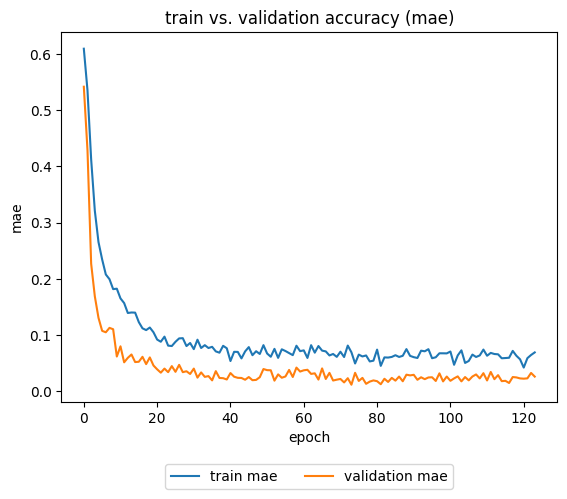

In [15]:
plt.plot(history.history['mae'], label='train mae'), 
plt.plot(history.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


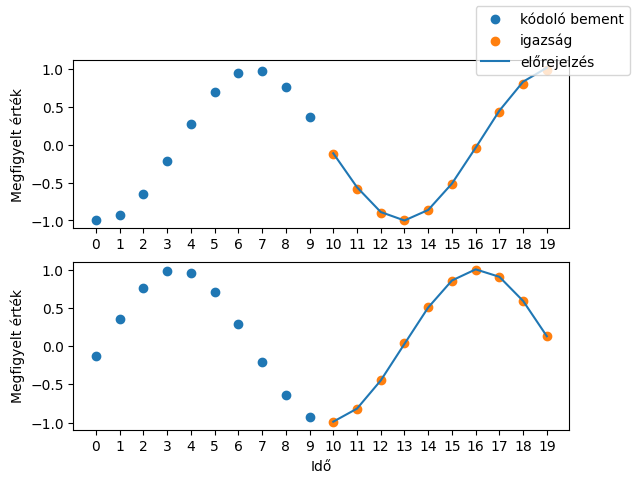

In [16]:
y_hat = seq2seq.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)

# Stacked model

In [17]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=3, model_type='stacked')

print(opt_model.best_args)



  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025C7BB0D300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
1/8 ━━━━━━━━━━━━━━━━━━━━ 6s 956ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step                                

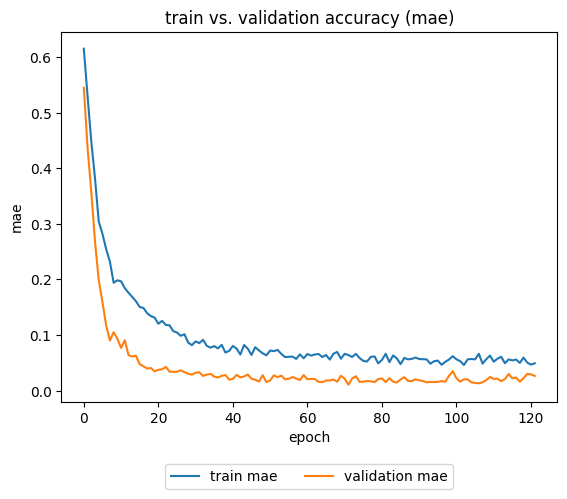

In [18]:
seq2seq_stacked = seq2seq_stacked_model(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"]
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50, restore_best_weights=True)

history_stacked = seq2seq_stacked.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=int(opt_model.best_args["batch_size"]), 
    shuffle=False,
    verbose=0,
    callbacks=[early_stop]
)

seq2seq.save(f'model_forecasting_seq2seq_{version}_stacked.keras')

plt.plot(history_stacked.history['mae'], label='train mae'), 
plt.plot(history_stacked.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


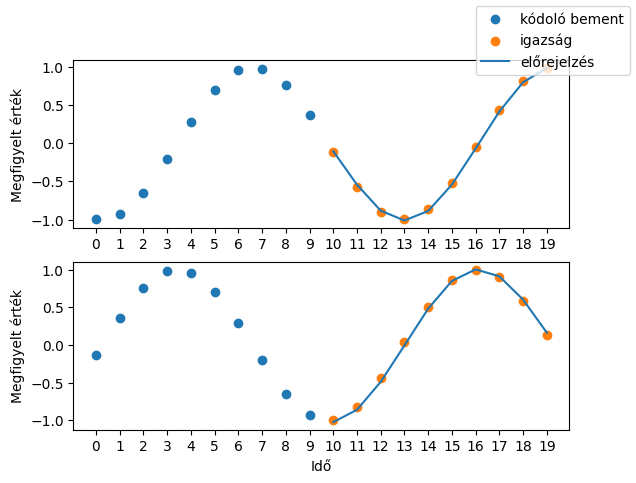

In [19]:
y_hat = seq2seq_stacked.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)

# Loung GRU figyelem

In [21]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=3, model_type='loung_gru')

print(opt_model.best_args)

seq2seq_attention = seq2seq_attention_model_gru(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"],
    attention_type='Loung'
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50, restore_best_weights=True)
history_attention = seq2seq_attention.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=int(opt_model.best_args["batch_size"]), 
    shuffle=False,
    verbose=0,
    validation_split=0.2, 
    callbacks=[early_stop]
)

seq2seq.save(f'model_forecasting_seq2seq_{version}_loung.keras')

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 704ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step         
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step         

100%|███████████████████████████████████████████████████| 3/3 [01:25<00:00, 28.34s/trial, best loss: 79.95573666023728]
Best hyperparameters: {'batch_size': np.float64(480.0), 'dropout': np.float64(0.1320590685132951), 'hidden_size': np.float64(70.0), 'lr': np.float64(0.0021720822588415043)}
{'batch_size': np.float64(480.0), 'dropout': np.float64(0.1320590685132951), 'hidden_size': np.float64(70.0), 'lr': np.float64(0.0021720822588415043)}


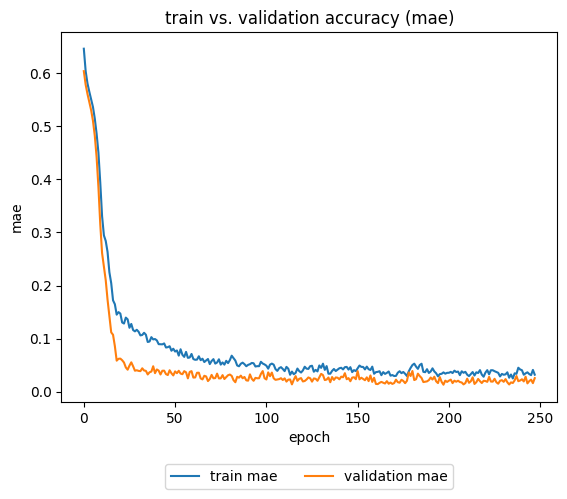

In [22]:
plt.plot(history_attention.history['mae'], label='train mae'), 
plt.plot(history_attention.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


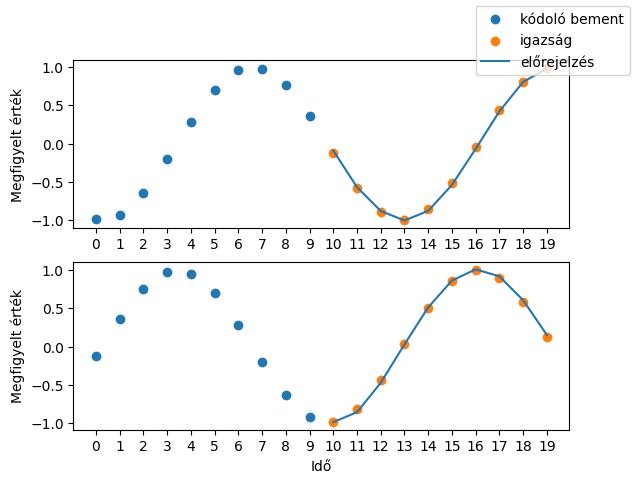

In [23]:
y_hat = seq2seq_attention.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)

# Bahdanau GRU figyelem

In [24]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=3, model_type='bahdanau_gru')

print(opt_model.best_args)

seq2seq_attention_b = seq2seq_attention_model_gru(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"],
    attention_type='Bahdanau'
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50)
history_attention_b = seq2seq_attention_b.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=110, 
    shuffle=False,
    verbose=0,
    validation_split=0.2, 
    callbacks=[early_stop]
)

seq2seq.save(f'model_forecasting_seq2seq_{version}_bahdanau.keras')

1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 599ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 4s 626ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step           
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step         

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 487ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step           

100%|███████████████████████████████████████████████████| 3/3 [02:06<00:00, 42.17s/trial, best loss: 84.90856939087618]
Best hyperparameters: {'batch_size': np.float64(980.0), 'dropout': np.float64(0.3690433222739268), 'hidden_size': np.float64(80.0), 'lr': np.float64(0.009818395527661661)}
{'batch_size': np.float64(980.0), 'dropout': np.float64(0.36904332227

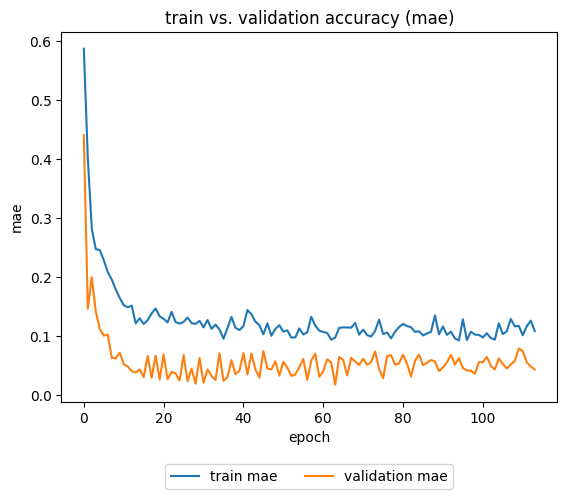

In [25]:
plt.plot(history_attention_b.history['mae'], label='train mae'), 
plt.plot(history_attention_b.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


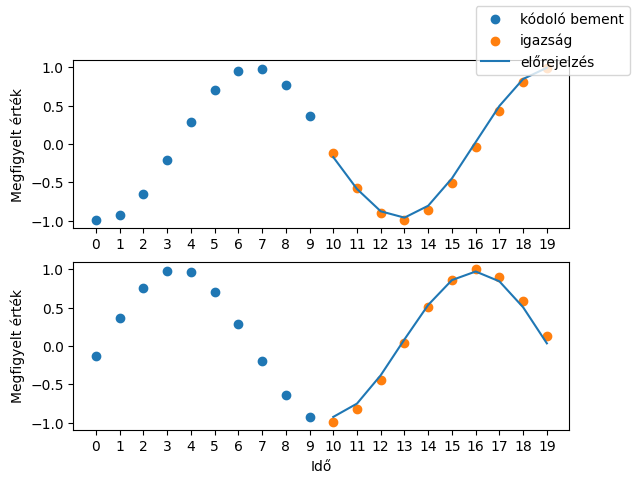

In [26]:
y_hat = seq2seq_attention_b.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)

# Loung LSTM figyelem

In [27]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=3, model_type='loung_lstm')

print(opt_model.best_args)

seq2seq_attention = seq2seq_attention_model_lstm(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"],
    attention_type='Loung'
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50, restore_best_weights=True)
history_attention = seq2seq_attention.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=int(opt_model.best_args["batch_size"]), 
    shuffle=False,
    verbose=0,
    validation_split=0.2, 
    callbacks=[early_stop]
)

seq2seq.save(f'model_forecasting_seq2seq_{version}_loung.keras')

1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step           
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step           

100%|███████████████████████████████████████████████████| 3/3 [01:56<00:00, 38.88s/trial, best loss: 69.89916566651206]
Best hyperparameters: {'batch_size': np.float64(520.0), 'dropout': np.float64(0.1056057856099471), 'hidden_size': np.float64(60.0), 'lr': np.float64(0.00012965602872183014)}
{'batch_size': np.float64(520.0), 'dropout': np.float64(0.105605785

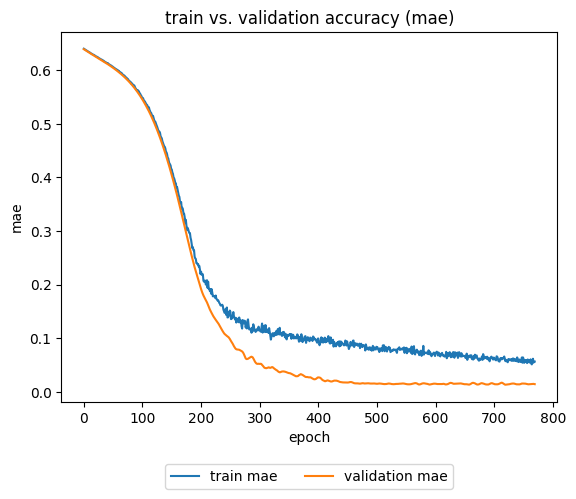

In [28]:
plt.plot(history_attention.history['mae'], label='train mae'), 
plt.plot(history_attention.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


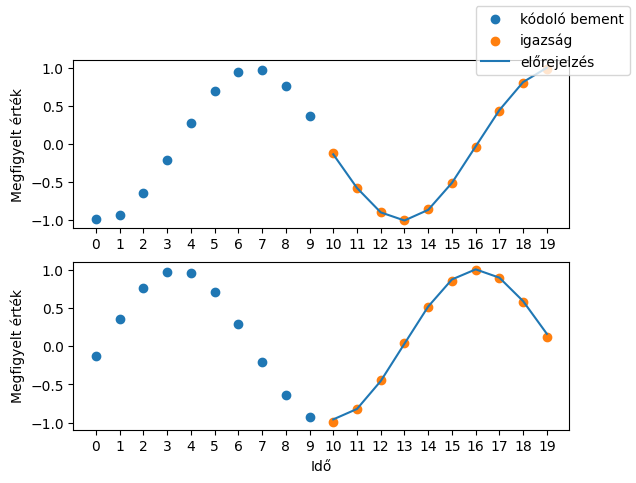

In [29]:
y_hat = seq2seq_attention.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)

# Bahdanau LSTM figyelem

In [30]:
space_seq2seq = {
    'hidden_size': hyperopt.hp.quniform("hidden_size", 20, 100, 10),
    'batch_size': hyperopt.hp.quniform("batch_size", 50, 1000, 20),
    'dropout': hyperopt.hp.uniform("dropout", 0.1, 0.5),
    'lr': hyperopt.hp.loguniform("lr", np.log(0.0001), np.log(0.1))
}
# hyperparamter optimalization
opt_model = HyperparamOpt(
    space=space_seq2seq
)

# predict with the optimized model
opt_model.train(X_train, y_train, X_val, y_val, X_test, y_test, max_eval=3, model_type='bahdanau_lstm')

print(opt_model.best_args)

seq2seq_attention_b = seq2seq_attention_model_lstm(
    hidden_size=int(opt_model.best_args["hidden_size"]), 
    dropout=opt_model.best_args["dropout"], 
    lr=opt_model.best_args["lr"],
    attention_type='Bahdanau'
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=50)
history_attention_b = seq2seq_attention_b.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs, 
    batch_size=110, 
    shuffle=False,
    verbose=0,
    validation_split=0.2, 
    callbacks=[early_stop]
)

seq2seq.save(f'model_forecasting_seq2seq_{version}_bahdanau.keras')

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step           
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step                                               
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step          
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step           

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step                                               
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step           
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step           

100%|███████████████████████████████████████████████████| 3/3 [01:24<00:00, 28.17s/trial, best loss: 83.70891520071581]
Best hyperparameters: {'batch_size': np.float64(520.0), 'dropout': np.float64(0.25900311510571605), 'hidden_size': np.float64(50.0), 'lr': np.float64(0.04

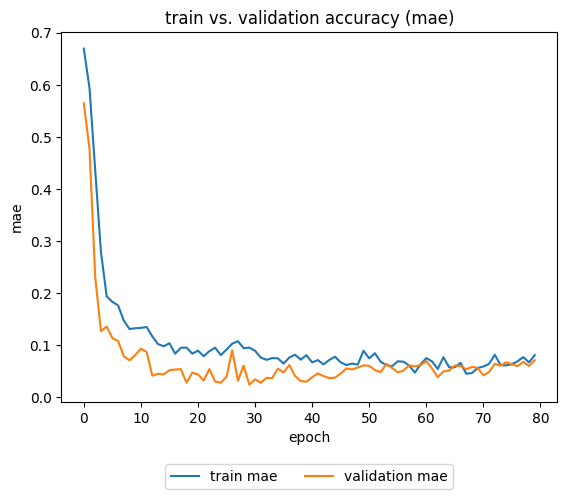

In [31]:
plt.plot(history_attention_b.history['mae'], label='train mae'), 
plt.plot(history_attention_b.history['val_mae'], label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


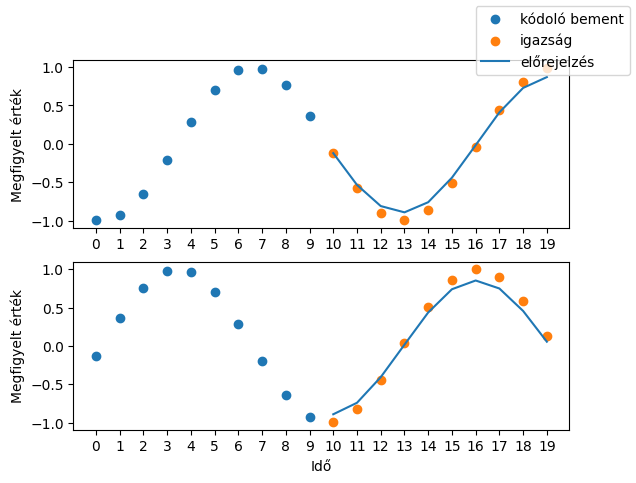

In [32]:
y_hat = seq2seq_attention_b.predict(X_test)

plot_serial(0, X_test, y_test, y_hat)